# FYP-DL: RNN Experimentation

# Imports

In [0]:
import numpy as np 
import pandas as pd 
import os 
np.random.seed(42)

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from google.colab import drive

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC

# Loading Data

In [0]:
ROOT_DIR = './'
MOUNT_DIR = os.path.join(ROOT_DIR, 'gdrive')
FYP_DIR = os.path.join(MOUNT_DIR, 'My Drive', 'EE 16-17 FYP DL Energy Theft Detection')
DATA_DIR = os.path.join(FYP_DIR, 'Data', 'full-processing-data')
DATA_FILE = os.path.join(DATA_DIR, 'outliersRemoved.csv')

In [0]:
drive.mount(MOUNT_DIR, force_remount=True)

Mounted at ./gdrive


In [0]:
data = pd.read_csv(DATA_FILE)

In [0]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


In [0]:
features, targets = data.iloc[:, 2:], data['FLAG']

# Train Test Split

In [0]:
# Remove any existing modules
!rm ./*.py

# Download from GH
!wget -q https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py
!wget -q https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/wdnn_transformers.py

In [0]:
from pipelines import get_feature_scaler, get_pipeline_1D

In [0]:
pipeline_1D = get_pipeline_1D(scaling_strategy='Standard')

In [0]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    features, targets, random_state=0, test_size=0.2, stratify=targets.values
)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=0, test_size=0.2, stratify=y_train_val.values
)

# Feature Scaling

In [0]:
X_train = pipeline_1D.fit_transform(X_train)
X_val = pipeline_1D.fit_transform(X_val)
X_test = pipeline_1D.fit_transform(X_test)

# Building RNN

In [0]:
NUM_X_TRAIN, NUM_X_VAL, NUM_X_TEST, *_ = [len(my_data) for my_data in [X_train, X_val, X_test]]

In [0]:
NUM_FEATURES = X_train.shape[-1]

In [0]:
X_train = X_train.reshape((NUM_X_TRAIN, NUM_FEATURES, 1))
X_test = X_test.reshape((NUM_X_TEST, NUM_FEATURES, 1))
X_val = X_val.reshape((NUM_X_VAL, NUM_FEATURES, 1))

In [0]:
rnn_model = Sequential()
rnn_model.add(Conv1D(12, 5, activation='relu', input_shape=(None, X_train.shape[-1])))
rnn_model.add(MaxPooling1D(5))
rnn_model.add(Conv1D(24, 5, activation='relu'))
rnn_model.add(MaxPooling1D(5))
rnn_model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.5))
rnn_model.add(Dense(1, activation='sigmoid'))

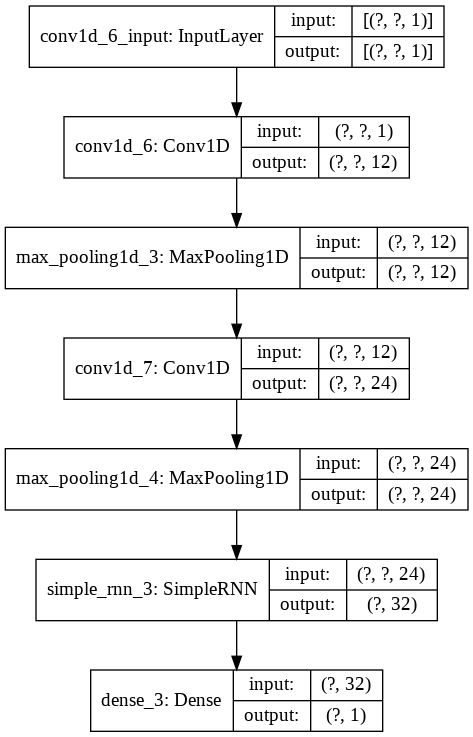

In [0]:
plot_model(rnn_model, show_shapes=True, show_layer_names=True)

In [0]:
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 12)          72        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 12)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 24)          1464      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 24)          0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                1824      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
____________________________________________________

In [0]:
rnn_model.compile(loss='binary_crossentropy', metrics=[AUC()], optimizer='rmsprop')

In [0]:
rnn_history = rnn_model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, 
                            validation_data=(X_val, y_val))

Epoch 1/10
848/848 [==============================] - 62s 73ms/step - loss: 0.2930 - auc_3: 0.5811 - val_loss: 0.2848 - val_auc_3: 0.6266
Epoch 2/10
848/848 [==============================] - 61s 72ms/step - loss: 0.2846 - auc_3: 0.6221 - val_loss: 0.2785 - val_auc_3: 0.6616
Epoch 3/10
848/848 [==============================] - 61s 72ms/step - loss: 0.2821 - auc_3: 0.6329 - val_loss: 0.2773 - val_auc_3: 0.6710
Epoch 4/10
848/848 [==============================] - 61s 72ms/step - loss: 0.2805 - auc_3: 0.6408 - val_loss: 0.2754 - val_auc_3: 0.6795
Epoch 5/10
848/848 [==============================] - 61s 72ms/step - loss: 0.2788 - auc_3: 0.6490 - val_loss: 0.2739 - val_auc_3: 0.6823
Epoch 6/10
848/848 [==============================] - 61s 72ms/step - loss: 0.2773 - auc_3: 0.6584 - val_loss: 0.2736 - val_auc_3: 0.6871
Epoch 7/10
848/848 [==============================] - 61s 72ms/step - loss: 0.2774 - auc_3: 0.6592 - val_loss: 0.2743 - val_auc_3: 0.6772
Epoch 8/10
848/848 [==============

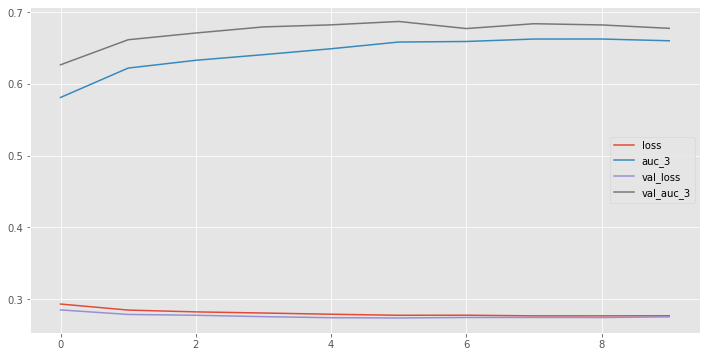

In [0]:
pd.DataFrame(rnn_history.history).plot(figsize=(12, 6))

In [0]:
plt.plot

In [0]:
stacked_rnn = Sequential()
stacked_rnn.add(SimpleRNN(input_shape=(None, X_train.shape[-1]), 
                                       units=8, return_sequences=True))
stacked_rnn.add(SimpleRNN(units=12, return_sequences=True))
stacked_rnn.add(SimpleRNN(1, activation='sigmoid'))

In [0]:
stacked_rnn.summary()

In [0]:
stacked_rnn.compile(loss='binary_crossentropy', metrics=[AUC()], optimizer='adam')

In [0]:
stacked_rnn_history = stacked_rnn.fit(X_train, y_train, epochs=10,
                                      validation_data=(X_val, y_val), batch_size=64)